In [2]:
import tensorflow as tf
import numpy as np
import random
import os

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [4]:
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import time
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random
import json
import tensorflow as tf
import kagglehub

In [5]:

# Download latest version
path = kagglehub.dataset_download("bhaveshmittal/melanoma-cancer-dataset")

print("Path to dataset files:", path)

Resuming download from 75497472 bytes (7726783 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/bhaveshmittal/melanoma-cancer-dataset?dataset_version_number=1 (75497472/83224255) bytes left.


100%|██████████| 79.4M/79.4M [00:00<00:00, 21.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bhaveshmittal/melanoma-cancer-dataset/versions/1


In [ ]:
with open("config", "r") as f:
    model_config = json.load(f)
model = keras.models.model_from_config(model_config)
model.load_weights("model.weights.h5")


# Data Preprocessing

In [238]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.4
)

train_generator = train_datagen.flow_from_directory(
    path + '/train',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=SEED
)

validation_generator = train_datagen.flow_from_directory(
    path + '/train',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    path + '/test',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=False,
    seed=SEED
)

Found 7128 images belonging to 2 classes.
Found 4751 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


# XAI HELPERS

In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
def predict_fn(images):
    preds = optimized_model.predict(images, verbose=0)
    return np.hstack([1 - preds, preds])

In [ ]:
target_coords = (IMAGE_WIDTH // 2, IMAGE_HEIGHT // 2)

In [320]:
def objective(img):
    img = np.clip(img, 0, 1)

    # Run LIME
    explanation = explainer.explain_instance(
        img.astype('double'),
        predict_fn,
        labels=(1,),       # Focus on Class 1 (Malignant)
        hide_color=0,
        num_samples=200,
        random_seed=42
    )

    # Get all superpixel weights for Class 1
    local_exp = explanation.local_exp[1] # List of (id, weight) tuples

    # Filter for POSITIVE weights only (features that support Malignant)
    positive_weights = [w for id, w in local_exp if w > 0]

    #sum them
    total_positive_importance = sum(positive_weights)

    return total_positive_importance

In [321]:
def get_image_and_mask(exp):
   # masks the positive lime scors
    temp, mask = exp.get_image_and_mask(
        exp.top_labels[0], #select the values for the winning class (positive / malignant in this case)
        positive_only=True,
        num_features=5,
        hide_rest=True
    )
    return mark_boundaries(temp / 2 + 0.5, mask)

In [ ]:
x_benign = None
x_malignant = None
#loop till we find an example from each class
max_batches = 20
batches_checked = 0

print("Searching for one Benign and one Malignant image...")

while (x_benign is None or x_malignant is None) and batches_checked < max_batches:
    try:
        batch_data = next(test_generator)
    except StopIteration:
        print("Generator ran out of data!")
        break
    images = batch_data[0]
    labels = batch_data[1]
    batches_checked += 1
    for i in range(len(labels)):
        if x_benign is None and labels[i] == 0:
            x_benign = images[i]
            print(f"  - Found Benign in batch {batches_checked}")

        if x_malignant is None and labels[i] == 1:
            x_malignant = images[i]
            print(f"  - Found Malignant in batch {batches_checked}")

        if x_benign is not None and x_malignant is not None:
            break
if x_benign is not None and x_malignant is not None:
    print("Success! You can now use:")
    print("x_original = x_benign      (for Benign)")
    print("x_original = x_malignant   (for Malignant)")
else:
    print("\nFailed. Could not find both classes even after checking multiple batches.")

Searching for one Benign and one Malignant image...
  - Found Benign in batch 1
  - Found Malignant in batch 3

Success! You can now use:
x_original = x_benign      (for Benign)
x_original = x_malignant   (for Malignant)


In [ ]:
explainer = lime_image.LimeImageExplainer()
x_original = x_malignant

# Simulated Annealing for LIME

In [ ]:
def simulated_annealing(x0, objective_fn, max_iter=50, temp=1.0, cooling_rate=0.85, step_size=0.1):
    current = x0.copy()
    try:
        current_score = objective_fn(current)
    except Exception as e:
        print(f"Error in initial objective calc: {e}")
        current_score = 0
    best = current.copy()
    best_score = current_score
    scores = [current_score]
    print(f"Initial Score: {current_score:.4f}")
    for i in range(max_iter):
        # Generate neighbor: Add noise to the image
        noise = np.random.normal(0, step_size, size=current.shape)
        neighbor = np.clip(current + noise, 0, 1)
        neighbor_score = objective_fn(neighbor)
        # Acceptance probability
        delta = neighbor_score - current_score
        if delta > 0 or np.exp(delta / temp) > random.random():
            current = neighbor
            current_score = neighbor_score
        # Track best
        if current_score > best_score:
            best = current.copy()
            best_score = current_score
            print(f"Iter {i}: New Best Score: {best_score:.4f}")

        temp *= cooling_rate
        scores.append(current_score)

    return best, best_score, scores

In [300]:
print("Starting Simulated Annealing... (This may take time)")
best_img, best_score, scores = simulated_annealing(
    x_original,
    objective,
    max_iter=20,
    temp=0.5,
    cooling_rate=0.6,
    step_size=0.08
)

Starting Simulated Annealing... (This may take time)


  0%|          | 0/200 [00:00<?, ?it/s]

Initial Score: 0.0214


  0%|          | 0/200 [00:00<?, ?it/s]

Iter 0: New Best Score: 0.0382


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Iter 13: New Best Score: 0.0391


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [301]:
print("Generating final explanations...")
exp_original = explainer.explain_instance(x_original.astype('double'), predict_fn, top_labels=1, num_samples=500)
exp_optimized = explainer.explain_instance(best_img.astype('double'), predict_fn, top_labels=1, num_samples=500)


Generating final explanations...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

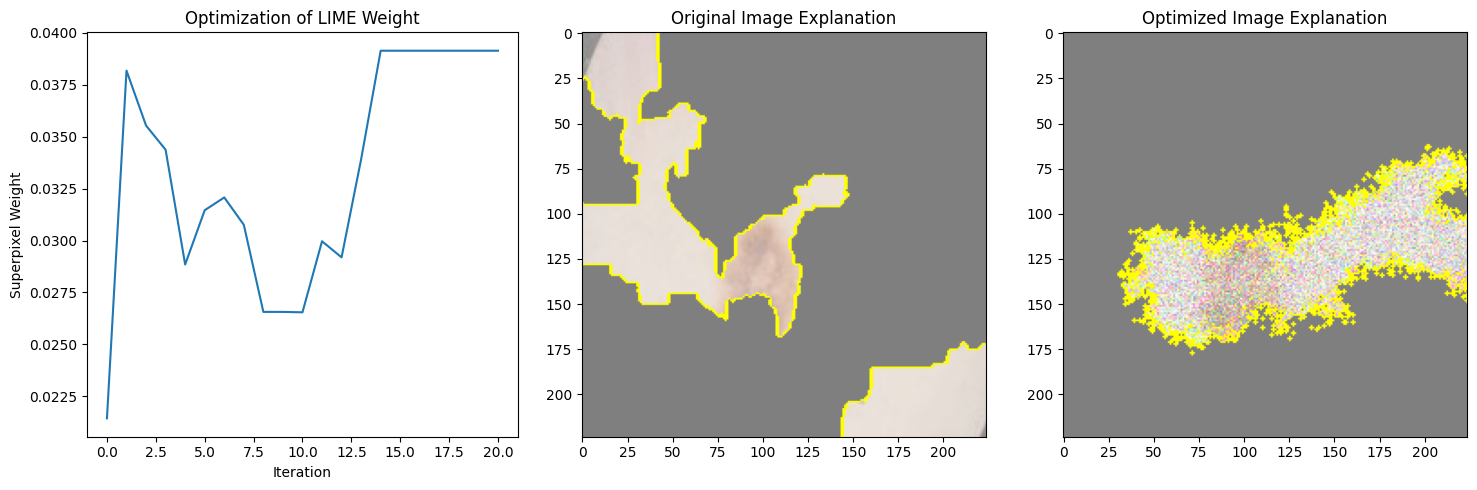

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Plot Optimization Curve
axes[0].plot(scores)
axes[0].set_title("Optimization of LIME Weight")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Superpixel Weight")
# Plot Original Explanation
axes[1].imshow(get_image_and_mask(exp_original))
axes[1].set_title("Original Image Explanation")

# Plot Optimized Explanation
axes[2].imshow(get_image_and_mask(exp_optimized))
axes[2].set_title("Optimized Image Explanation")

plt.tight_layout()
plt.show()

# Tabu for LIME

In [ ]:
def get_neighbours(current_img, original_img, num_neighbors=4, step_size=0.1, max_perturbation=0.5):
    neighbours = []
    for _ in range(num_neighbors):
        noise = np.random.normal(0, step_size, current_img.shape)
        #Calculate the proposed new image
        proposed = current_img + noise
        # Calculate the diff
        diff = proposed - original_img
        # Clip 
        diff = np.clip(diff, -max_perturbation, max_perturbation)
        #Reconstruct and clip to valid pixel range [0,1]
        n_img = np.clip(original_img + diff, 0, 1)
        neighbours.append(n_img)
    return neighbours

In [ ]:
def tabu_search(start_image, max_iter=20, tabu_tenure=5):
    current = start_image.copy()
    current_score = objective(current)
    best = current.copy()
    best_score = current_score
    # Tabu list: Stores hash of image bytes -> remaining tenure
    tabu_list = {}
    history_log = [current_score]
    print("===== TABU SEARCH STARTED =====")
    print(f"Initial LIME Weight: {current_score:.4f}")
    print("=" * 60)
    for i in range(max_iter):
        print(f"--- Iteration {i+1}/{max_iter} ---")
        # Generate neighbors with constraint
        neighbours = get_neighbours(current, start_image)
        neighbor_candidates = []
        # Evaluate neighbors
        for n in neighbours:
            n_key = hash(n.tobytes())
            # Check Tabu Status
            is_tabu = n_key in tabu_list and tabu_list[n_key] > 0
            score = objective(n)
            if is_tabu:
                # Aspiration Criteria: If it's Tabu but better than global best, allow it
                if score > best_score:
                    print(f"   -> Aspiration! Tabu neighbor accepted with score {score:.4f}")
                    neighbor_candidates.append((n, score))
            else:
                neighbor_candidates.append((n, score))
        if not neighbor_candidates:
            print("No admissible neighbors found.")
            break
        # Select Best Neighbor (Greedy)
        best_candidate, best_candidate_score = max(neighbor_candidates, key=lambda x: x[1])
        print(f"   -> Best neighbor score: {best_candidate_score:.4f}")
        # Update Tabu List
        # Decrement existing
        expired = [k for k, v in tabu_list.items() if v <= 1]
        for k in expired: del tabu_list[k]
        for k in tabu_list: tabu_list[k] -= 1
        # Add current selection
        tabu_list[hash(best_candidate.tobytes())] = tabu_tenure
        # Move
        current = best_candidate
        # Update Global Best
        if best_candidate_score > best_score:
            best = current.copy()
            best_score = best_candidate_score
            print(f"   *** NEW GLOBAL BEST: {best_score:.4f} ***")
        history_log.append(best_candidate_score)
    print("===== COMPLETED =====")
    return best, best_score, history_log

In [317]:
print("Running Tabu Search on LIME explanation...")
# Reduced max_iter because LIME is slow (each iter runs LIME 5 times)
final_img, final_score, history = tabu_search(x_original, max_iter=15, tabu_tenure=3)

Running Tabu Search on LIME explanation...


  0%|          | 0/200 [00:00<?, ?it/s]

===== TABU SEARCH STARTED =====
Initial LIME Weight: 0.0217
--- Iteration 1/15 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

   -> Best neighbor score: 0.0356
   *** NEW GLOBAL BEST: 0.0356 ***
--- Iteration 2/15 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

   -> Best neighbor score: 0.0445
   *** NEW GLOBAL BEST: 0.0445 ***
--- Iteration 3/15 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

   -> Best neighbor score: 0.0402
--- Iteration 4/15 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

   -> Best neighbor score: 0.0404
--- Iteration 5/15 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

   -> Best neighbor score: 0.0354
--- Iteration 6/15 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

   -> Best neighbor score: 0.0351
--- Iteration 7/15 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

   -> Best neighbor score: 0.0355
--- Iteration 8/15 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

   -> Best neighbor score: 0.0388
--- Iteration 9/15 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

   -> Best neighbor score: 0.0362
--- Iteration 10/15 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

   -> Best neighbor score: 0.0424
--- Iteration 11/15 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

   -> Best neighbor score: 0.0388
--- Iteration 12/15 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

   -> Best neighbor score: 0.0427
--- Iteration 13/15 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

   -> Best neighbor score: 0.0386
--- Iteration 14/15 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

   -> Best neighbor score: 0.0393
--- Iteration 15/15 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

   -> Best neighbor score: 0.0416
===== COMPLETED =====


In [319]:
exp_original = explainer.explain_instance(x_original.astype('double'), predict_fn, top_labels=1, num_samples=500)
exp_optimized = explainer.explain_instance(final_img.astype('double'), predict_fn, top_labels=1, num_samples=500)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

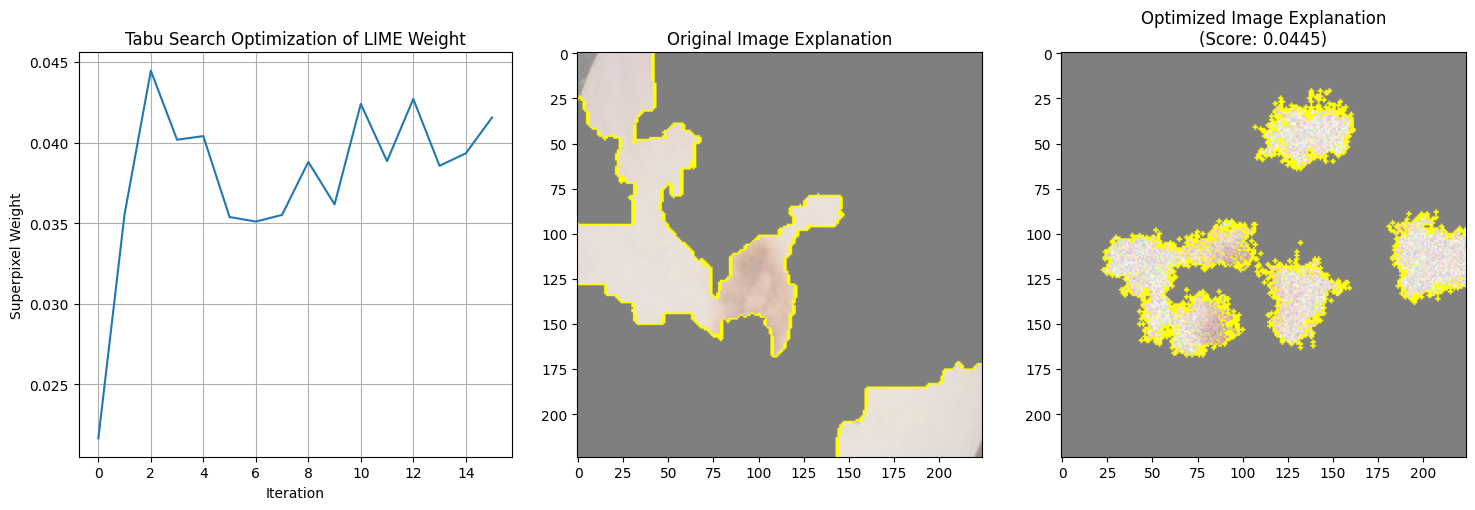

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(history)
axes[0].set_title("Tabu Search Optimization of LIME Weight")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Superpixel Weight")
axes[0].grid(True)
axes[1].imshow(get_image_and_mask(exp_original))
axes[1].set_title("Original Image Explanation")
axes[2].imshow(get_image_and_mask(exp_optimized))
axes[2].set_title(f"Optimized Image Explanation\n(Score: {final_score:.4f})")
plt.tight_layout()
plt.show()

# Grey wolf for LIME

In [ ]:
def grey_wolf_optimizer_lime(original_img, max_iter=20, pop_size=6, max_perturbation=0.5):
    # Dimensions of the search space (H, W, C)
    dim = original_img.shape
    # Initialize Population (Wolves)
    # start with the original image + small  noise
    population = []
    for _ in range(pop_size):
        noise = np.random.normal(0, 0.02, dim)
        wolf = np.clip(original_img + noise, 0, 1)
        population.append(wolf)
    population = np.array(population)
    # Initialize Alpha, Beta, Delta
    # We maximize so initialize with -infinity
    alpha_pos = np.zeros(dim)
    alpha_score = -float('inf')
    beta_pos = np.zeros(dim)
    beta_score = -float('inf')
    delta_pos = np.zeros(dim)
    delta_score = -float('inf')
    history_log = []
    print("===== GREY WOLF OPTIMIZER STARTED =====")
    print(f"Population: {pop_size}, Max Iter: {max_iter}")
    for it in range(max_iter):
        print(f"--- Iteration {it+1}/{max_iter} ---")
        # Evaluate fitness of all wolves
        for i in range(pop_size):
            fitness = objective(population[i])
            # Update Alpha, Beta, Delta
            if fitness > alpha_score:
                # Demote Alpha to Beta, Beta to Delta
                delta_score = beta_score
                delta_pos = beta_pos.copy()
                beta_score = alpha_score
                beta_pos = alpha_pos.copy()
                # Update Alpha
                alpha_score = fitness
                alpha_pos = population[i].copy()
                print(f"   -> New Alpha found! Score: {alpha_score:.4f}")
            elif fitness > beta_score:
                delta_score = beta_score
                delta_pos = beta_pos.copy()
                beta_score = fitness
                beta_pos = population[i].copy()
            elif fitness > delta_score:
                delta_score = fitness
                delta_pos = population[i].copy()
        history_log.append(alpha_score)
        # Update positions of wolves
        # a decreases from 2 to 0
        a = 2 - it * (2 / max_iter)
        for i in range(pop_size):
            for j in range(dim[0]): # Iterate rows (vectorized over cols/channels for speed)
                 # Helper to compute X1, X2, X3 vectors
                 def get_update_vector(leader_pos):
                     r1 = np.random.random((dim[1], dim[2]))
                     r2 = np.random.random((dim[1], dim[2]))
                     A = 2 * a * r1 - a
                     C = 2 * r2
                     D_leader = np.abs(C * leader_pos[j] - population[i, j])
                     X_new = leader_pos[j] - A * D_leader
                     return X_new
                 X1 = get_update_vector(alpha_pos)
                 X2 = get_update_vector(beta_pos)
                 X3 = get_update_vector(delta_pos)
                 # Average the vectors
                 population[i, j] = (X1 + X2 + X3) / 3.0
            # Apply CONSTRAINTS to noise
            diff = population[i] - original_img
            diff = np.clip(diff, -max_perturbation, max_perturbation)
            population[i] = np.clip(original_img + diff, 0, 1)
    print("===== GWO COMPLETED =====")
    return alpha_pos, alpha_score, history_log

In [326]:
print("Running GWO on LIME explanation...")
final_img, final_score, history = grey_wolf_optimizer_lime(x_original, max_iter=10, pop_size=6)

Running GWO on LIME explanation...
===== GREY WOLF OPTIMIZER STARTED =====
Population: 6, Max Iter: 10
--- Iteration 1/10 ---


  0%|          | 0/200 [00:00<?, ?it/s]

   -> New Alpha found! Score: 0.0224


  0%|          | 0/200 [00:00<?, ?it/s]

   -> New Alpha found! Score: 0.0285


  0%|          | 0/200 [00:00<?, ?it/s]

   -> New Alpha found! Score: 0.0325


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

--- Iteration 2/10 ---


  0%|          | 0/200 [00:00<?, ?it/s]

   -> New Alpha found! Score: 0.0358


  0%|          | 0/200 [00:00<?, ?it/s]

   -> New Alpha found! Score: 0.0374


  0%|          | 0/200 [00:00<?, ?it/s]

   -> New Alpha found! Score: 0.0378


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

--- Iteration 3/10 ---


  0%|          | 0/200 [00:00<?, ?it/s]

   -> New Alpha found! Score: 0.0431


  0%|          | 0/200 [00:00<?, ?it/s]

   -> New Alpha found! Score: 0.0434


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

   -> New Alpha found! Score: 0.0492


  0%|          | 0/200 [00:00<?, ?it/s]

--- Iteration 4/10 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

--- Iteration 5/10 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

--- Iteration 6/10 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

--- Iteration 7/10 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

--- Iteration 8/10 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

--- Iteration 9/10 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

--- Iteration 10/10 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

===== GWO COMPLETED =====


In [327]:
exp_original = explainer.explain_instance(x_original.astype('double'), predict_fn, top_labels=1, num_samples=500)
exp_optimized = explainer.explain_instance(final_img.astype('double'), predict_fn, top_labels=1, num_samples=500)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

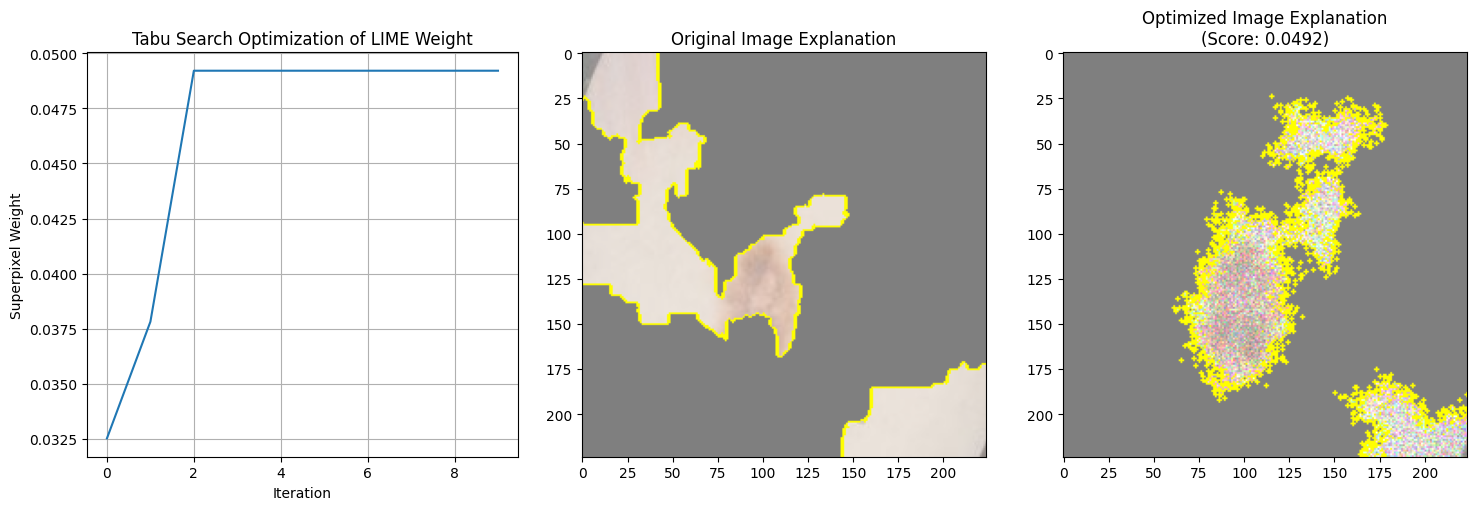

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(history)
axes[0].set_title("Tabu Search Optimization of LIME Weight")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Superpixel Weight")
axes[0].grid(True)
axes[1].imshow(get_image_and_mask(exp_original))
axes[1].set_title("Original Image Explanation")
axes[2].imshow(get_image_and_mask(exp_optimized))
axes[2].set_title(f"Optimized Image Explanation\n(Score: {final_score:.4f})")
plt.tight_layout()
plt.show()

# Cukoo search for LIME

In [ ]:
def get_levy_step(shape, lambda_val=1.5):
    sigma_u = (math.gamma(1 + lambda_val) * math.sin(math.pi * lambda_val / 2) / \
               (math.gamma((1 + lambda_val) / 2) * lambda_val * (2**((lambda_val - 1) / 2))))**(1 / lambda_val)
    sigma_v = 1
    u = np.random.normal(0, sigma_u**2, shape)
    v = np.random.normal(0, sigma_v**2, shape)
    step = u / (np.abs(v)**(1 / lambda_val))
    return step

In [ ]:
def cuckoo_search_lime(original_img, max_iter=15, n_nests=6, pa=0.25, alpha=0.01, max_perturbation=0.5):
    nests = []
    fitness = []
    print("===== CUCKOO SEARCH STARTED =====")
    print(f"Nests: {n_nests}, Max Iter: {max_iter}")
    # Initialize population
    for _ in range(n_nests):
        noise = np.random.normal(0, 0.02, original_img.shape)
        nest_img = np.clip(original_img + noise, 0, 1)
        nests.append(nest_img)
        fitness.append(objective(nest_img))
    nests = np.array(nests)
    fitness = np.array(fitness)
    # Get initial best
    best_idx = np.argmax(fitness)
    best_nest = nests[best_idx].copy()
    best_score = fitness[best_idx]
    history_log = [best_score]
    # Main Loop
    for it in range(max_iter):
        print(f"--- Iteration {it+1}/{max_iter} ---")
        # Generate New Cuckoos via Levy Flights
        for i in range(n_nests):
            current_nest = nests[i]
            # Levy Flight Step
            step = get_levy_step(current_nest.shape)
            step_size = alpha * step * (current_nest - best_nest)
            new_cuckoo = current_nest + step_size
            # CONSTRAIN
            diff = new_cuckoo - original_img
            diff = np.clip(diff, -max_perturbation, max_perturbation)
            new_cuckoo = np.clip(original_img + diff, 0, 1)
            new_score = objective(new_cuckoo)
            if new_score > fitness[i]:
                nests[i] = new_cuckoo
                fitness[i] = new_score
        #Abandon Worse Nests
        sorted_indices = np.argsort(fitness)
        n_abandon = int(pa * n_nests)
        for k in range(n_abandon):
            idx_to_replace = sorted_indices[k]
            noise = np.random.normal(0, 0.02, original_img.shape)
            new_nest = np.clip(original_img + noise, 0, 1)
            nests[idx_to_replace] = new_nest
            fitness[idx_to_replace] = objective(new_nest)
        #Update Global best
        current_best_idx = np.argmax(fitness)
        if fitness[current_best_idx] > best_score:
            best_score = fitness[current_best_idx]
            best_nest = nests[current_best_idx].copy()
            print(f"   -> New Global Best: {best_score:.4f}")
        history_log.append(best_score)
    print("===== CUCKOO SEARCH COMPLETED =====")
    return best_nest, best_score, history_log

In [332]:
print("Running Cuckoo Search on LIME explanation...")
final_img, final_score, history = cuckoo_search_lime(x_original, max_iter=10, n_nests=6)

Running Cuckoo Search on LIME explanation...
===== CUCKOO SEARCH STARTED =====
Nests: 6, Max Iter: 10


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

--- Iteration 1/10 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

--- Iteration 2/10 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

--- Iteration 3/10 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

--- Iteration 4/10 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

--- Iteration 5/10 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

--- Iteration 6/10 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

--- Iteration 7/10 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

--- Iteration 8/10 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

--- Iteration 9/10 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

   -> New Global Best: 0.0369
--- Iteration 10/10 ---


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

===== CUCKOO SEARCH COMPLETED =====


In [333]:
exp_original = explainer.explain_instance(x_original.astype('double'), predict_fn, top_labels=1, num_samples=500)
exp_optimized = explainer.explain_instance(final_img.astype('double'), predict_fn, top_labels=1, num_samples=500)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

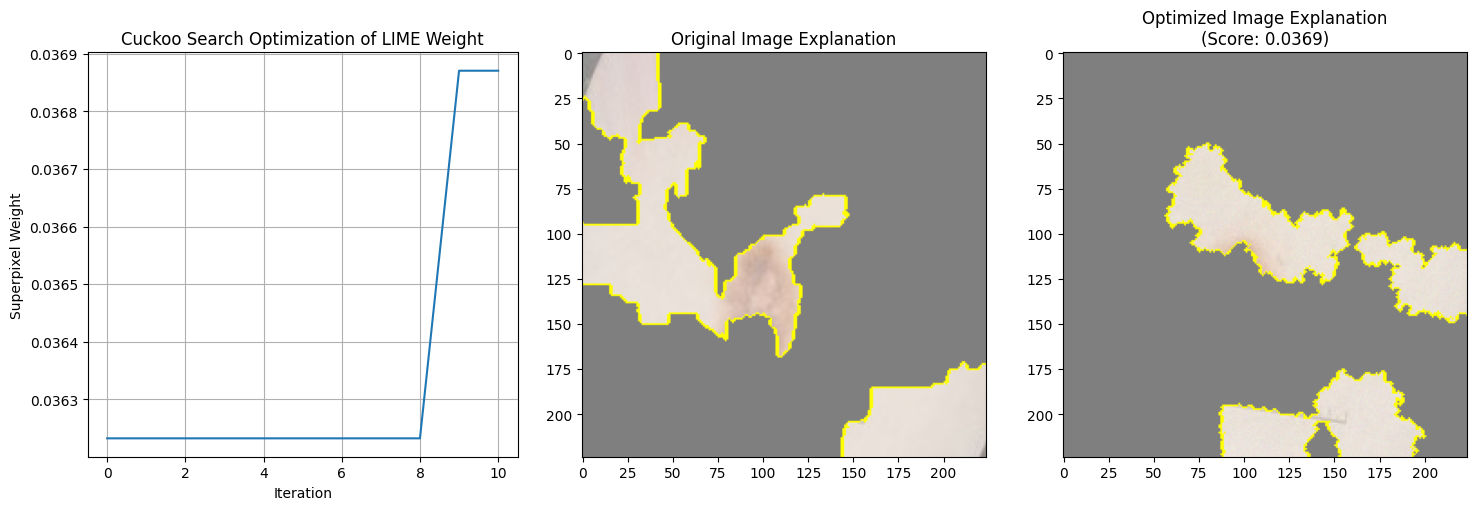

In [334]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(history)
axes[0].set_title("Cuckoo Search Optimization of LIME Weight")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Superpixel Weight")
axes[0].grid(True)
axes[1].imshow(get_image_and_mask(exp_original))
axes[1].set_title("Original Image Explanation")
axes[2].imshow(get_image_and_mask(exp_optimized))
axes[2].set_title(f"Optimized Image Explanation\n(Score: {final_score:.4f})")

plt.tight_layout()
plt.show()